# Neural Networks assignment

In this assignment, we are going to practice learning with neural networks using a *regression* example.

## Software setup
This code will be run in Python 3, and we need to install a few Python packages. To avoid interference with other
system packages, we basically have two alternatives. We could setup a virtual environment with tools like `virtualenv`
or `anaconda`. Alternatively, we can use online Python interpreters, like Google Colab.

As in the tutorial, you *may* use [Google Colab](https://colab.research.google.com) following the instructions below.

Instructions:
1. Head to Google Colab at: https://colab.research.google.com
2. If you don't have a Google account, you might have to create one.
3. Login with your account
4. At the Welcome screen, select the Upload tab and then upload this notebook file.
5. If you miss the Welcome screen, at the Google Colab notebook view, you can go to:
File -> Upload...
6. After uploading the notebook, upload the data set `rock_properties.csv` file via the "Files" menu at the upper half
of the edge of the Colab screen on the left-hand side. Another option is to upload it using Colab's library. For that,
enter the following in a code cell:
```python
from google.colab import files
uploaded = files.upload()
```
Then run the cell and select the CSV file to upload using the "Choose file" button which will show up under the cell.

You are now all set to run this notebook.

In [9]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange

plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [2]:
# A function to train a neural network

def train(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
          n_it=1000, lr=1e-2, weight_decay=0, verbose=True):
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = torch.zeros(n_it)
    iterator = trange(n_it) if verbose else range(n_it)
    for t in iterator:
        opt.zero_grad()
        loss = loss_fn(model(x), y.view(-1, 1))
        train_losses[t] = loss.detach()
        loss.backward()
        opt.step()
        if verbose:
            iterator.set_postfix(loss=loss.item())
    return train_losses

In [3]:
# A function for plotting via Matplotlib

def plot_predictions(model: nn.Module, x: torch.Tensor, y: torch.Tensor, loss_values: torch.Tensor):
    pred_class = torch.where(model(x).view(-1) > 0, torch.ones_like(y), torch.zeros_like(y)).int()

    plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.scatter(x[:, 0], x[:, 1], c=y.int().numpy(), cmap=colormap)
    plt.title("True classes")


    plt.subplot(132)
    plt.scatter(x[:, 0], x[:, 1], c=pred_class.numpy(), cmap=colormap)
    plt.title("Predicted classes")

    plt.subplot(133)
    plt.plot(loss_values)
    plt.ylim(0, 1)
    plt.title("Losses")

# Regression problem

We will continue working with the rock properties dataset from the tutorial.
This time we will use a neural network to infer the relationship between the porosity and the density of a rock.

Recall that for regression, we predict continuous variables. For this we then need to use a

## Rock data

In [4]:
os.chdir("/Users/megannguyen/Desktop/DATA 5711")
dataset = pd.read_csv("rock_properties.csv")
dataset

,feature,ufi,siteid,sampleid,well_name,latitude,longitude,dscription,lith_group,unitname,...,magsus_min,magsus_std,surf_type,magsus_cor,magsus_mul,density_db,density_wb,density_g,porosity_a,porosity_t
0,RPROP,1,NaN,TAN99AD179,NaN,-20.325941,129.365882,aphyric basalt,mafic extrusive,Dead Bullock Formation,...,NaN,NaN,irregular_surface,no,NaN,2.970,2.98,2.99,0.58,NaN
1,RPROP,2,NaN,TAN99AD281,NaN,-20.699759,129.641569,amphibolite,mafic intrusive,Dead Bullock Formation,...,NaN,NaN,irregular_surface,no,NaN,2.750,2.76,2.76,0.19,NaN
2,RPROP,3,NaN,TAN99AD331,NaN,-20.518587,130.380842,biotite diorite,intermediate intrusive,Dead Bullock Formation,...,NaN,NaN,cut_surface,no,NaN,2.960,2.97,2.99,1.11,NaN
3,RPROP,4,NaN,TAN99AD331,NaN,-20.518587,130.380842,biotite diorite,intermediate intrusive,Dead Bullock Formation,...,NaN,NaN,cut_surface,no,NaN,2.990,2.99,3.00,0.18,NaN
4,RPROP,5,NaN,TAN99AD331,NaN,-20.518587,130.380842,biotite diorite,intermediate intrusive,Dead Bullock Formation,...,NaN,NaN,cut_surface,no,NaN,3.040,3.05,3.05,0.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,RPROP,225,NaN,tan99ajc78,NaN,-19.105967,130.075332,rhyodacite/dacite,felsic extrusive,Ware Group,...,NaN,NaN,irregular_surface,no,NaN,2.640,2.66,2.70,2.28,NaN
225,RPROP,226,NaN,2121/1,BMR Lucas 25,-20.739595,128.763763,Palaeozoic cover,clastic sediment,NaN,...,NaN,NaN,cut_surface,no,NaN,2.642,2.66,2.69,1.84,NaN
226,RPROP,227,NaN,2121/2,BMR Lucas 25,-20.739595,128.763763,Palaeozoic cover,clastic sediment,NaN,...,NaN,NaN,cut_surface,no,NaN,2.639,2.66,2.68,1.62,NaN
227,RPROP,228,NaN,2122/2,BMR Lucas 26,-20.768595,128.767929,Palaeozoic cover,clastic sediment,NaN,...,NaN,NaN,cut_surface,no,NaN,2.518,2.56,2.63,4.38,NaN


In [5]:
lith_group = dataset['lith_group']

classes = ['clastic sediment', 'felsic intrusive'] #label encoding
covariates = ['porosity_a', 'density_g']
n_data_dim = len(covariates)
n_data = len(dataset)

data_idx = [i for i,l in enumerate(lith_group) if l in classes] 

data_labels = lith_group[data_idx]
data_points = torch.from_numpy(np.stack([dataset[a][data_idx] for a in covariates], axis=1)).float()
n_data_entries = data_labels.shape[0]

data_targets = torch.tensor([classes.index(d) for d in data_labels]).float() 

# Shuffle data
data_shuffled_idx = torch.randperm(n_data_entries).numpy()
data_labels = np.asarray(data_labels)[data_shuffled_idx]
data_points = data_points[data_shuffled_idx]
data_targets = data_targets[data_shuffled_idx]

# Split training and test sets
train_frac = 0.8
n_train = int(train_frac * n_data_entries)
n_test = n_data - n_train
train_points = data_points[:n_train]
train_targets = data_targets[:n_train]
test_points = data_points[n_train:]
test_targets = data_targets[n_train:]

(0.0, 25.0, 2.0, 3.5)

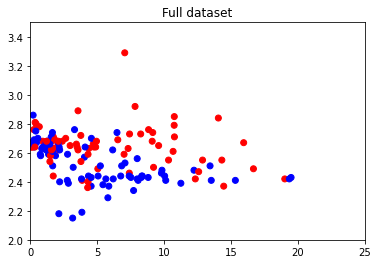

In [11]:
extent = [0, 25, 2, 3.5]
plt.scatter(data_points[:, 0], data_points[:, 1], c=data_targets, cmap=colormap)
plt.title("Full dataset")
plt.axis(extent)

(0.0, 25.0, 2.0, 3.5)

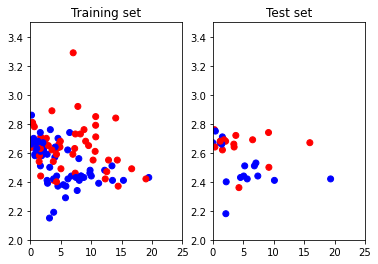

In [12]:
plt.subplot(121)
plt.scatter(train_points[:, 0], train_points[:, 1], c=train_targets, cmap=colormap)
plt.title("Training set")
plt.axis(extent)

plt.subplot(122)
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_targets, cmap=colormap)
plt.title("Test set")
plt.axis(extent)

<b>Problem</b>: Implement and train a neural network model with PyTorch to learn a regression model with the data above.
Feel free to use any combination of layers and activation functions. You are also allowed to use the `train()` function.
After training, test the model on the test data
as given above.

100%|██████████| 4000/4000 [00:20<00:00, 190.62it/s, loss=0.176]


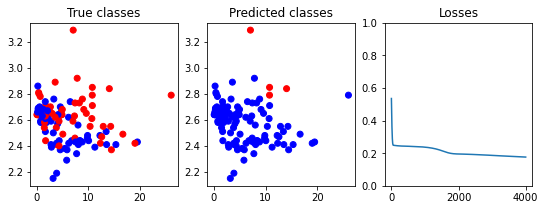

In [17]:
n_dim = 2
n_class = 2         # 2 classes, as we are doing binary classification
n_hidden = 16            # number of hidden units in each NN layer
n_hidden_layers = 1     # number of hidden layers in the NN
mlp = nn.Sequential(*(  
        [nn.Linear(n_dim, n_hidden), nn.Sigmoid()] # the first layer needs to match the input dimensions with the data
         + [nn.Linear(n_hidden, n_hidden), nn.Sigmoid()]*n_hidden_layers   # intermediate hidden layers using Sigmoid activation fn
         +[nn.Linear(n_hidden, 1)]) # the output layer maps the last hidden layer to the scalar output
                    )
losses = train(mlp, train_points, train_targets, lr=1e-3, n_it=4000)

plot_predictions(mlp, train_points, train_targets, losses)

In [18]:
test_loss_fn = nn.BCEWithLogitsLoss()

mlp_test_loss = test_loss_fn(mlp(test_points), test_targets.view(-1, 1))

print(f"Test losses:\nMLP: {mlp_test_loss:.2f}")

Test losses:
MLP: 0.65
